# Simulation Study

In [1]:
from preamble import *

%config InlineBackend.figure_format = 'retina'
%load_ext lab_black

In [2]:
# dill.load_session("Sim_NegBin_Weibull.pkl")

In [3]:
import sys

print("ABC version:", abc.__version__)
print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("PyMC3 version:", pm.__version__)
print("Arviz version:", arviz.__version__)

tic()

ABC version: 0.1.0
Python version: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
Numpy version: 1.20.3
PyMC3 version: 3.11.2
Arviz version: 0.11.2


In [4]:
numIters = numItersData = 10
popSize = 1000
smcArgs = {"verbose": True, "numProcs": 40}

## Inference of a Negative Binomial - Weibull model

In this notebook we are are conducting a simulation experiment where the claim frequency are Negative Binomial distributed 

$$
n_s\underset{\textbf{i.i.d.}}{\sim}\text{Neg-Bin}(\alpha = 4, p = 2/3),\text{ }s = 1,\ldots, 30
$$ 

and the individual claim sizes are weibull distributed

$$
u_1,\ldots, u_{n_s}\underset{\textbf{i.i.d.}}{\sim}\text{Weib}(k = 1/2, \beta = 1),\text{ }s = 1,\ldots 30.
$$ 

The available data is aggregated claim sizes in excess of the priority $c=1$ asociated to aa global stop-loss treaty, we have 

$$
x_s = \left(\sum_{k = 1}^{n_s}u_k-c\right)_{+},\text{ }s = 1,\ldots, t.
$$

Our aim is to look into the finite sample performance of our ABC implementation when the model is well specified that is when we assume a negative binomial - weibull model

In [5]:
rg = default_rng(123)

sample_sizes = [50, 250]
T = sample_sizes[-1]
t = np.arange(1, T + 1, 1)

# Frequency-Loss Model
α, p, k, β = 4, 2 / 3, 1 / 3, 1
θ_True = α, p, k, β
θ_sev = k, β
θ_freq = α, p
freq = "negative binomial"
sev = "weibull"

# Aggregation process
c = 1
psi = abc.Psi("GSL", c)

freqs, sevs = abc.simulate_claim_data(rg, T, freq, sev, θ_True)
df_full = pd.DataFrame(
    {
        "time_period": np.concatenate([np.repeat(s, freqs[s - 1]) for s in t]),
        "claim_size": sevs,
    }
)

xData = abc.compute_psi(freqs, sevs, psi)

df_agg = pd.DataFrame({"time_period": t, "N": freqs, "X": xData})

In [6]:
[np.sum(xData[:ss] > 0) for ss in sample_sizes]

[23, 130]

## True posterior samples

We run a Bayesian analysis on the individual claim data and frequency data so as to infer the parameters of the Weibull, distribution. The prior distribution on the parameters are taken as independent uniform distribution (as in the ABC approach). 

### Fitting a Weibull model to the individual loss data

The number of individual claim sizes is  98


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.001
Stage:   2 Beta: 0.015
Stage:   3 Beta: 0.066
Stage:   4 Beta: 0.158
Stage:   5 Beta: 0.419
Stage:   6 Beta: 1.000


CPU times: user 1.66 s, sys: 320 ms, total: 1.98 s
Wall time: 18.4 s
The number of individual claim sizes is  525


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.003
Stage:   3 Beta: 0.014
Stage:   4 Beta: 0.035
Stage:   5 Beta: 0.094
Stage:   6 Beta: 0.292
Stage:   7 Beta: 0.993
Stage:   8 Beta: 1.000


CPU times: user 1.73 s, sys: 19.3 ms, total: 1.75 s
Wall time: 1.75 s


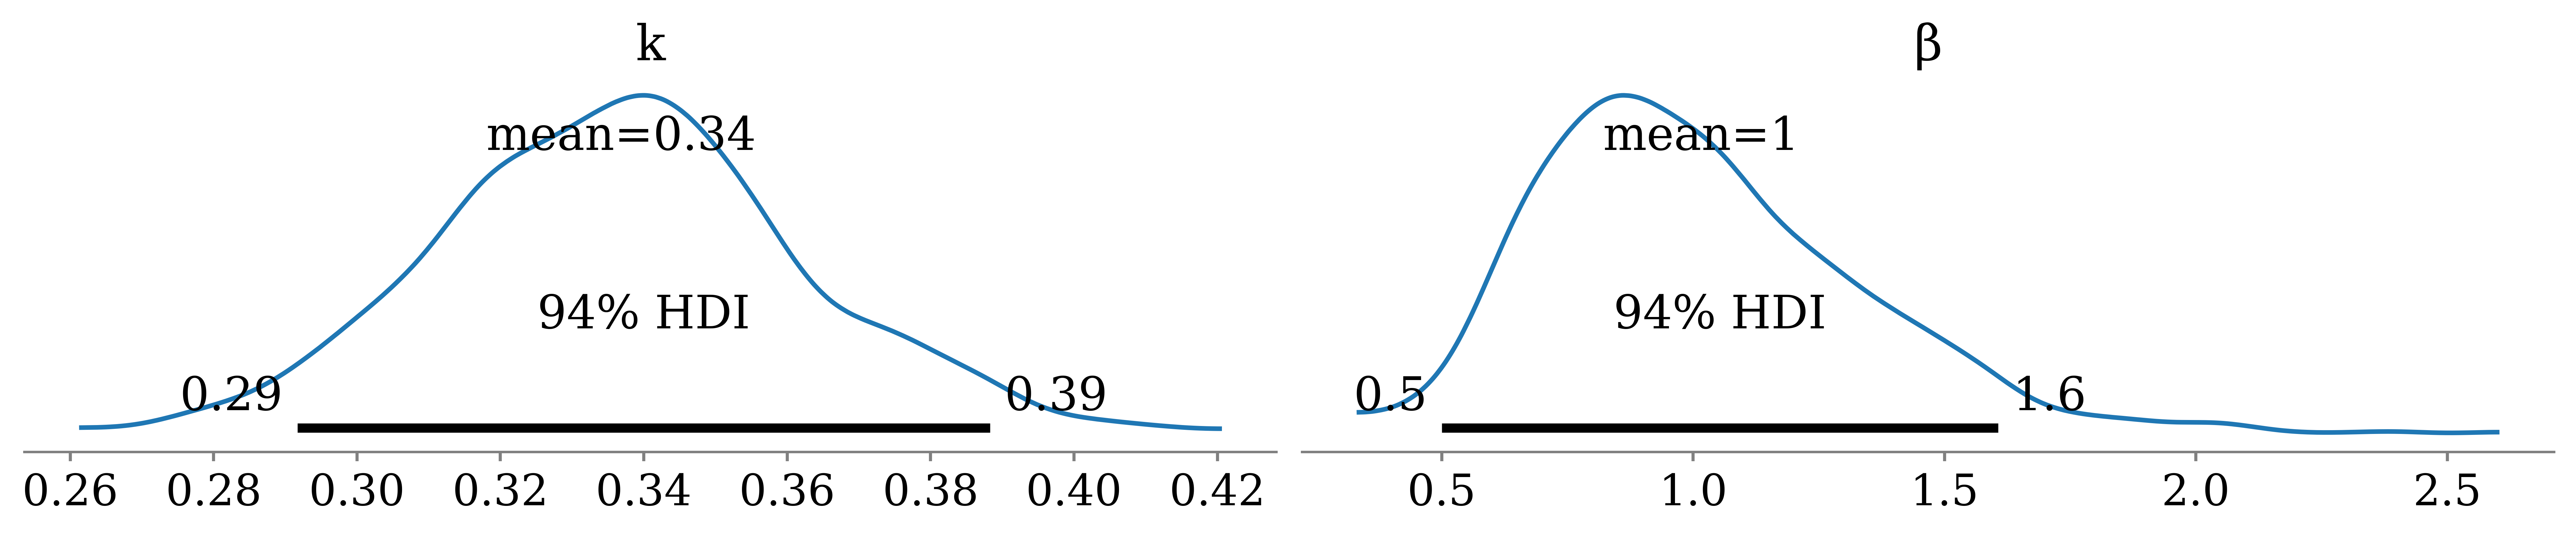

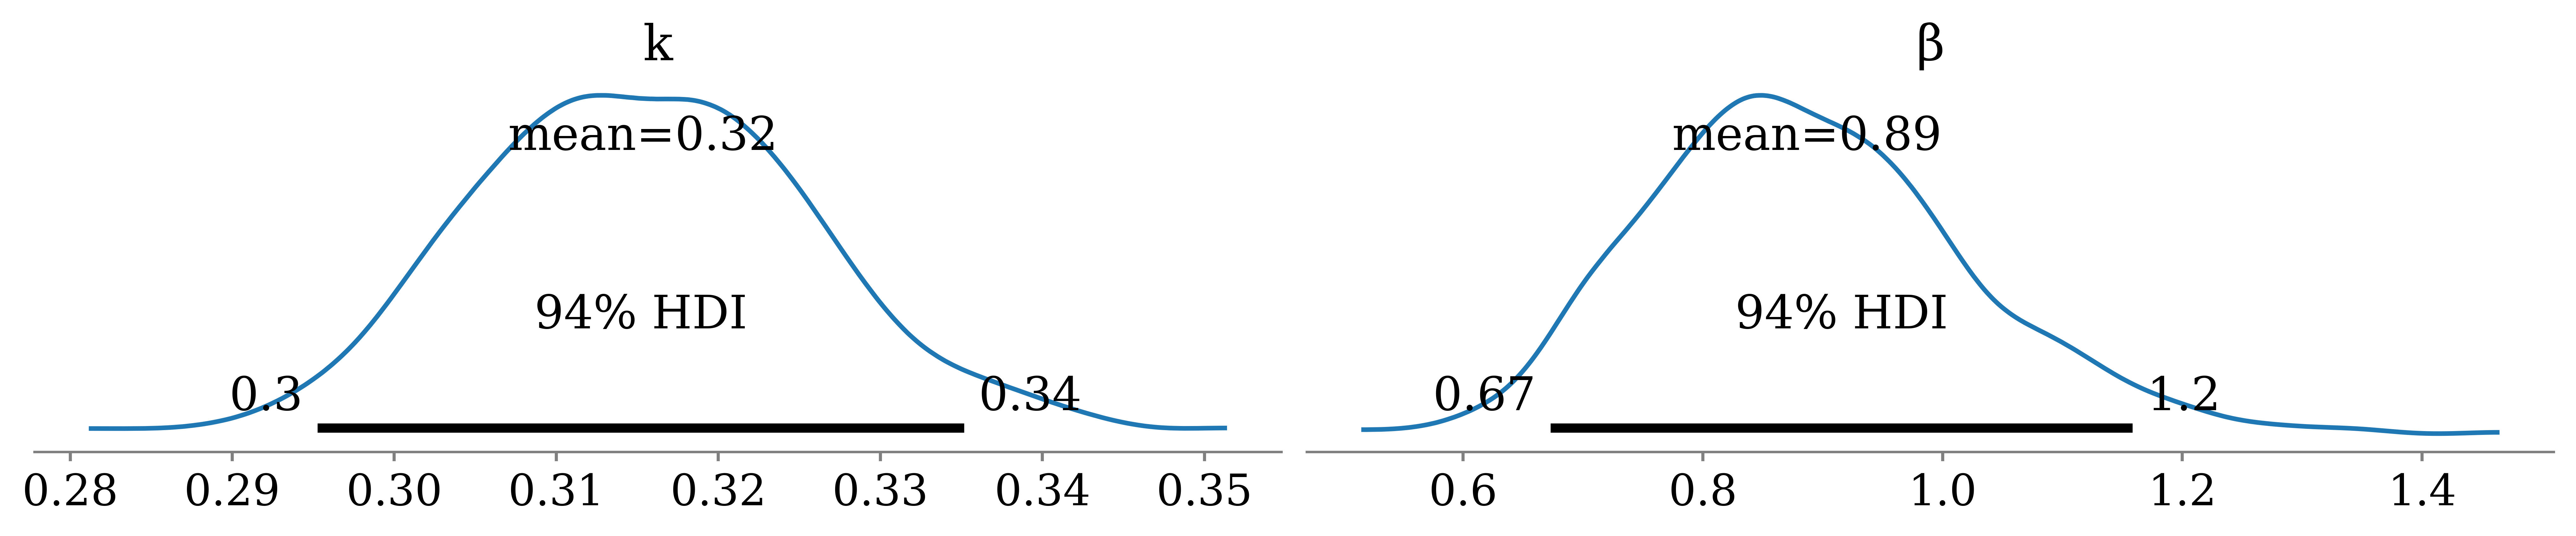

In [7]:
dfsev = pd.DataFrame({"ss": [], "k": [], "β": []})

for ss in sample_sizes:

    uData = np.array(df_full.claim_size[df_full.time_period <= ss])
    print("The number of individual claim sizes is ", len(uData))

    with pm.Model() as model_weib:
        k = pm.Uniform("k", lower=1e-1, upper=10)
        β = pm.Uniform("β", lower=0, upper=20)
        X = pm.Weibull("X", alpha=k, beta=β, observed=uData)

        %time trace = pm.sample_smc(popSize, random_seed=1, chains = 1)
        arviz.plot_posterior(trace)

    res = pd.DataFrame({"ss": np.repeat(ss, popSize), "k": trace["k"], "β": trace["β"]})
    dfsev = pd.concat([dfsev, res])

### Fitting a Negative Binomial model to the claim frequency data

Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.025
Stage:   1 Beta: 0.189
Stage:   2 Beta: 1.000


CPU times: user 1.23 s, sys: 177 ms, total: 1.41 s
Wall time: 10.6 s


Initializing SMC sampler...
Sampling 1 chain in 1 job
Stage:   0 Beta: 0.005
Stage:   1 Beta: 0.039
Stage:   2 Beta: 0.224
Stage:   3 Beta: 0.817
Stage:   4 Beta: 1.000


CPU times: user 1.42 s, sys: 4.18 ms, total: 1.42 s
Wall time: 1.42 s


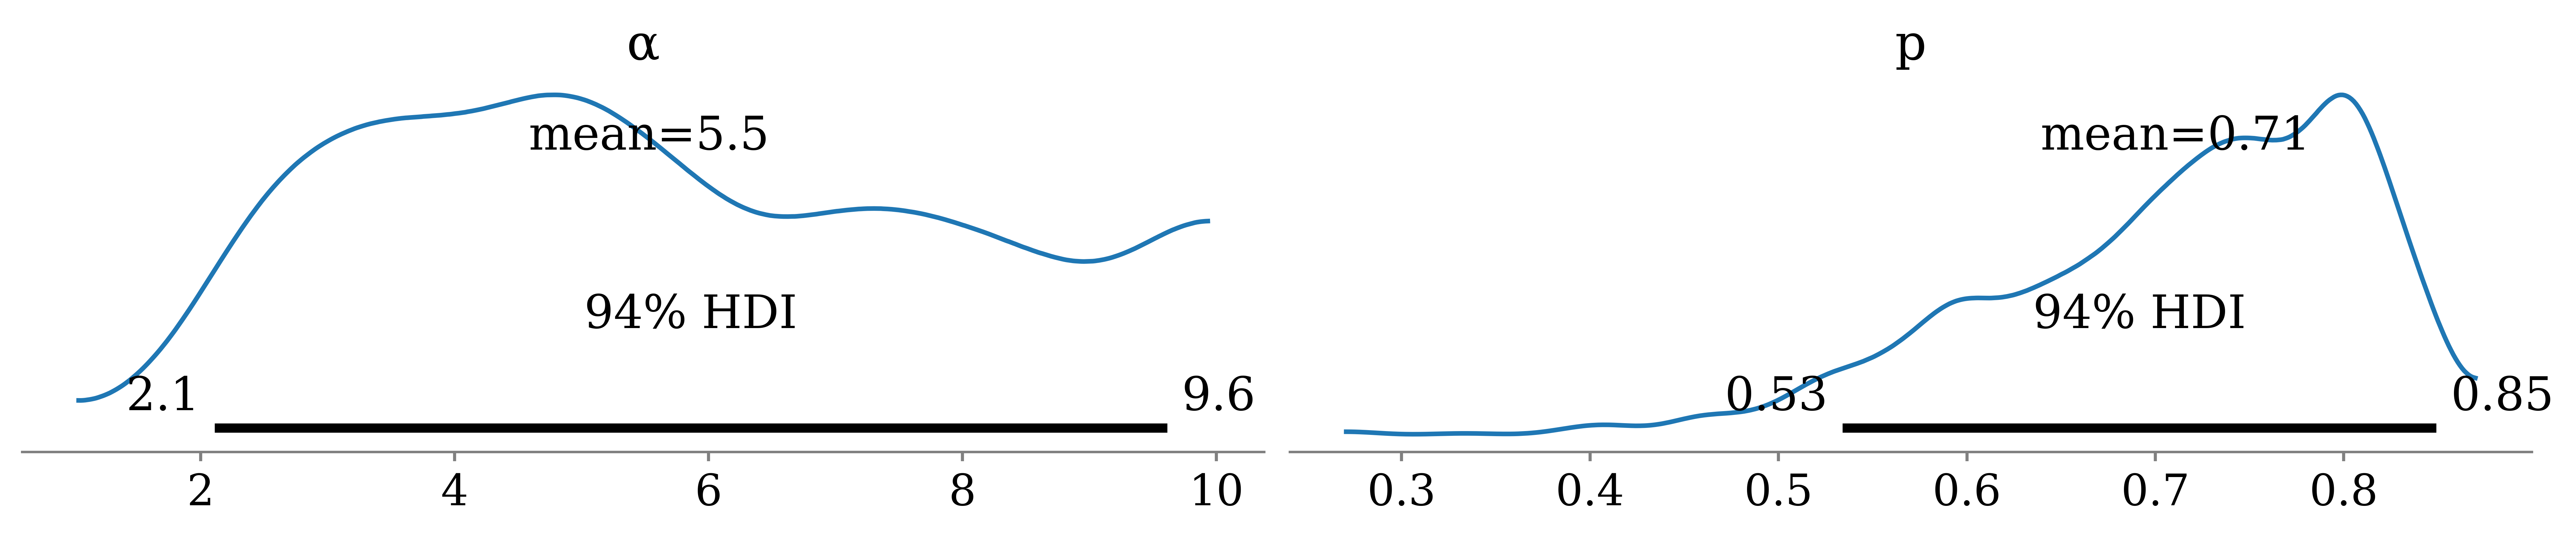

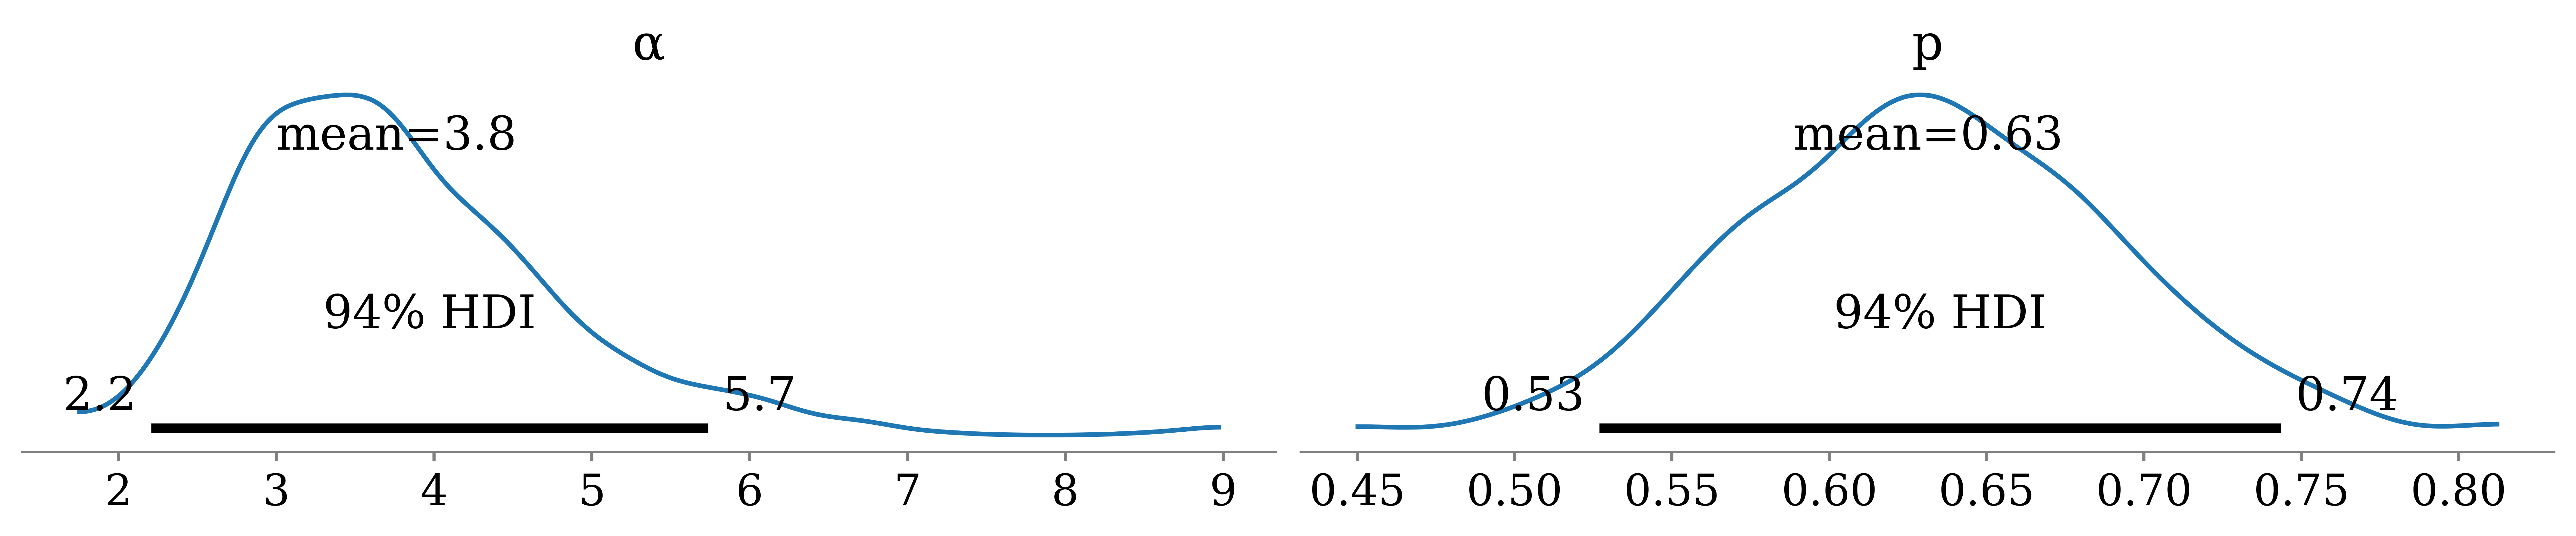

In [8]:
dffreq = pd.DataFrame({"ss": [], "α": [], "p": []})

for ss in sample_sizes:
    nData = df_agg.N[df_agg.time_period <= ss]
    with pm.Model() as model_negbin:
        α = pm.Uniform("α", lower=0, upper=10)
        p = pm.Uniform("p", lower=1e-3, upper=1)
        N = pm.NegativeBinomial("N", mu=α * (1 - p) / p, alpha=α, observed=nData)

        %time trace = pm.sample_smc(popSize, random_seed=1, chains = 1)
        arviz.plot_posterior(trace)

    res = pd.DataFrame({"ss": np.repeat(ss, popSize), "α": trace["α"], "p": trace["p"]})
    dffreq = pd.concat([dffreq, res])

We store all the posterior samples in one single data frame

In [9]:
dftrue = pd.concat([dffreq, dfsev.drop("ss", axis=1)], axis=1)
dftrue["posterior"] = np.repeat("True", len(dftrue))

## ABC posterior for the negative-binomial-Weibull model

In [10]:
params = ("α", "p", "k", "β")
prior = abc.IndependentUniformPrior([(0, 10), (1e-3, 1), (1e-1, 10), (0, 20)], params)
model = abc.Model("negative binomial", "weibull", psi, prior)

In [11]:
dfABC = pd.DataFrame({"ss": [], "weights": [], "α": [], "p": [], "r": [], "m": []})

for ss in sample_sizes:
    xDataSS = df_agg.X[df_agg.time_period <= ss].to_numpy()

    %time fit = abc.smc(numIters, popSize, xDataSS, model, **smcArgs)

    res = pd.DataFrame(
        {
            "ss": np.repeat(ss, popSize),
            "weights": fit.weights,
            "α": fit.samples[:, 0],
            "p": fit.samples[:, 1],
            "k": fit.samples[:, 2],
            "β": fit.samples[:, 3],
        }
    )

    dfABC = pd.concat([dfABC, res])

Final population dists <= 7.28, ESS = 794
CPU times: user 14.9 s, sys: 1.66 s, total: 16.5 s
Wall time: 1min 31s


Final population dists <= 4.55, ESS = 776
CPU times: user 22.8 s, sys: 1.75 s, total: 24.6 s
Wall time: 2min 34s


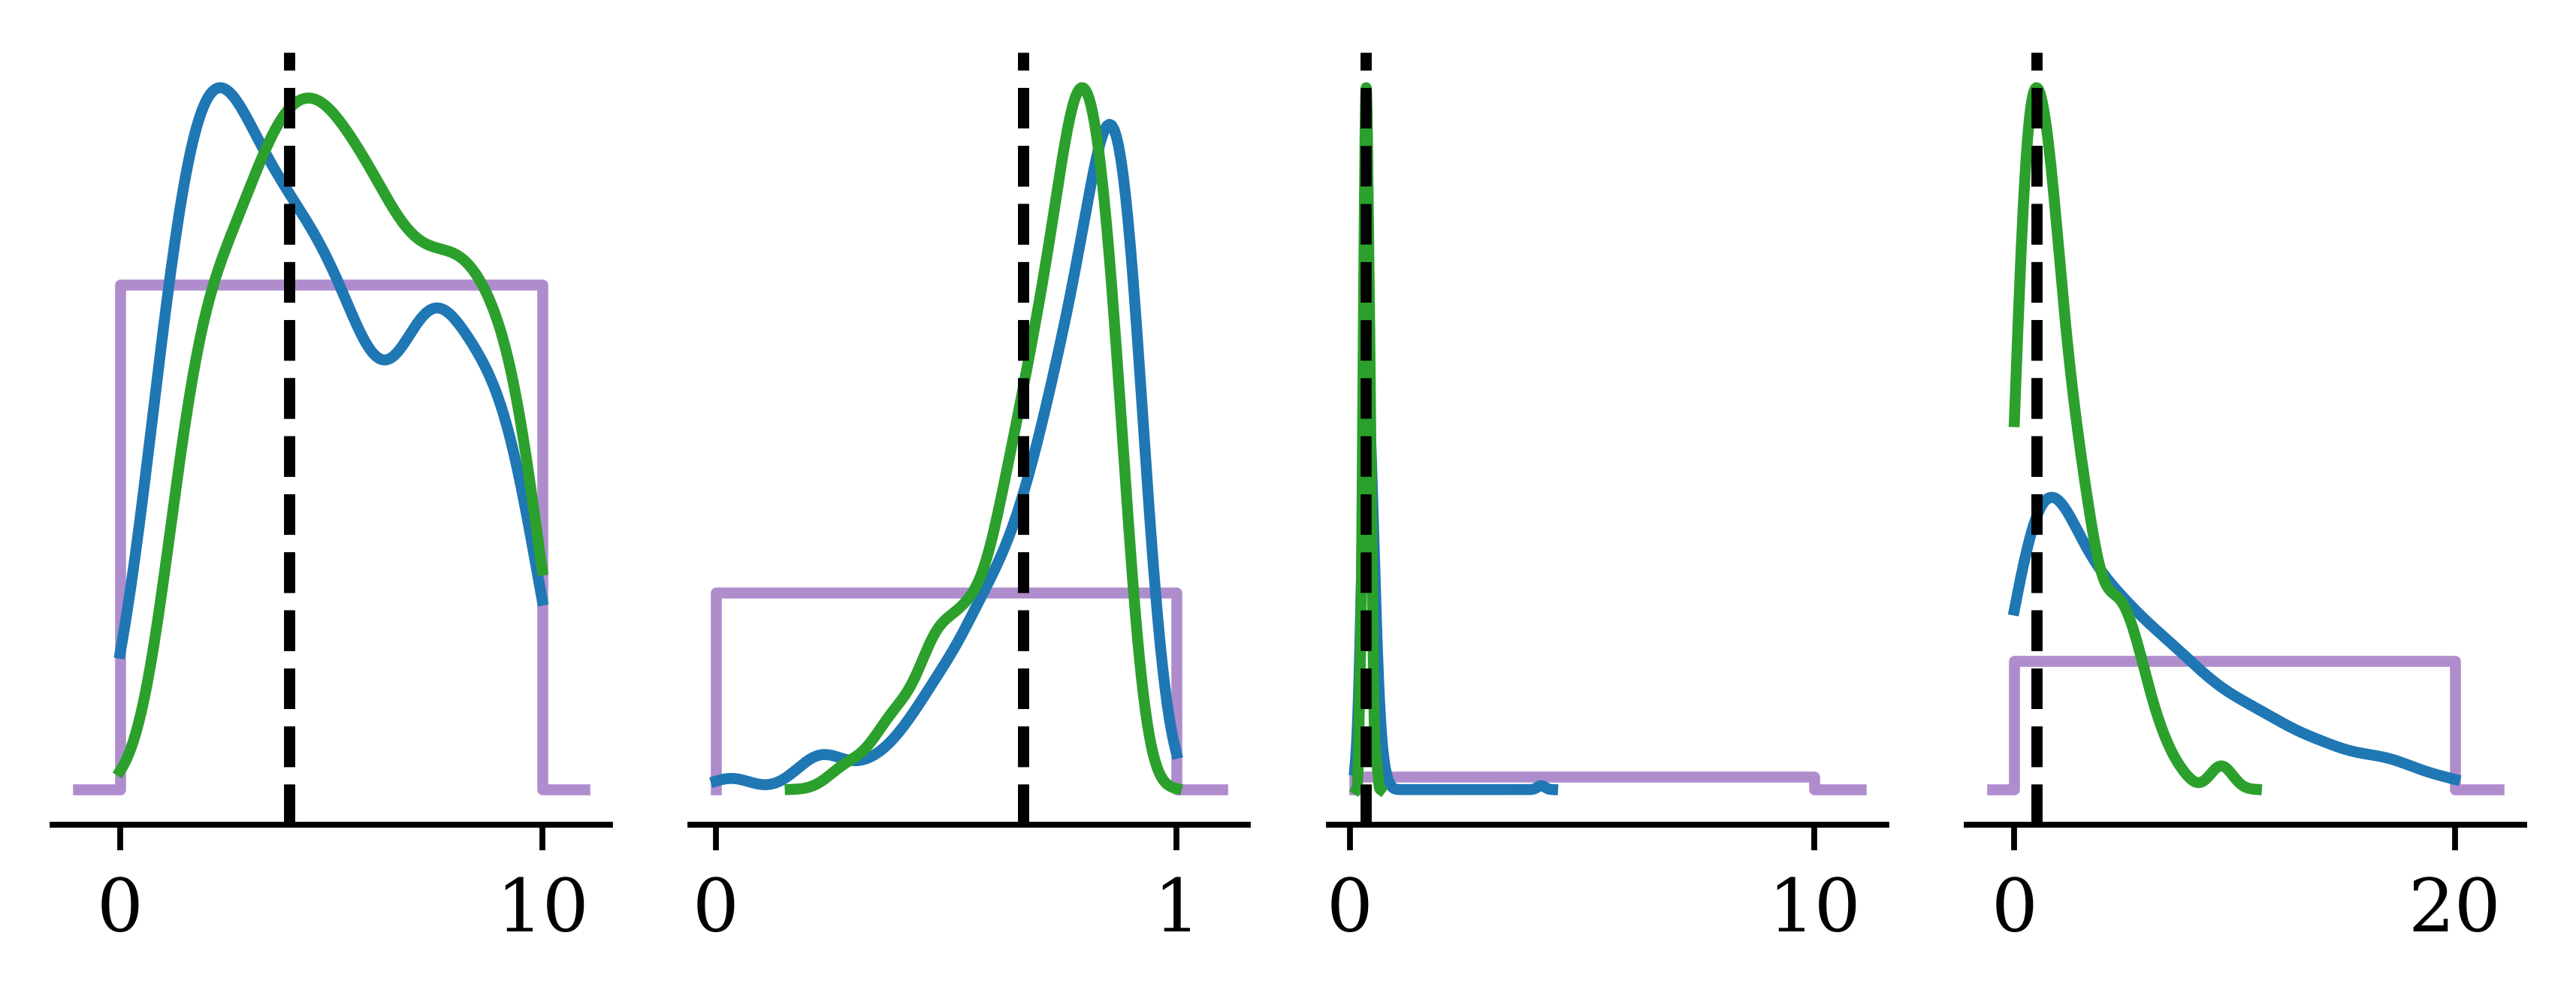

In [12]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abc.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")
        axs[l].axvline(θ_True[l], **trueStyle)
        # axs[l].set_title("$" + params[l] + "$")
        axs[l].set_yticks([])

draw_prior(prior, axs)
sns.despine(left=True)
save_cropped("../Figures/hist-test1-negbin-weib.pdf")

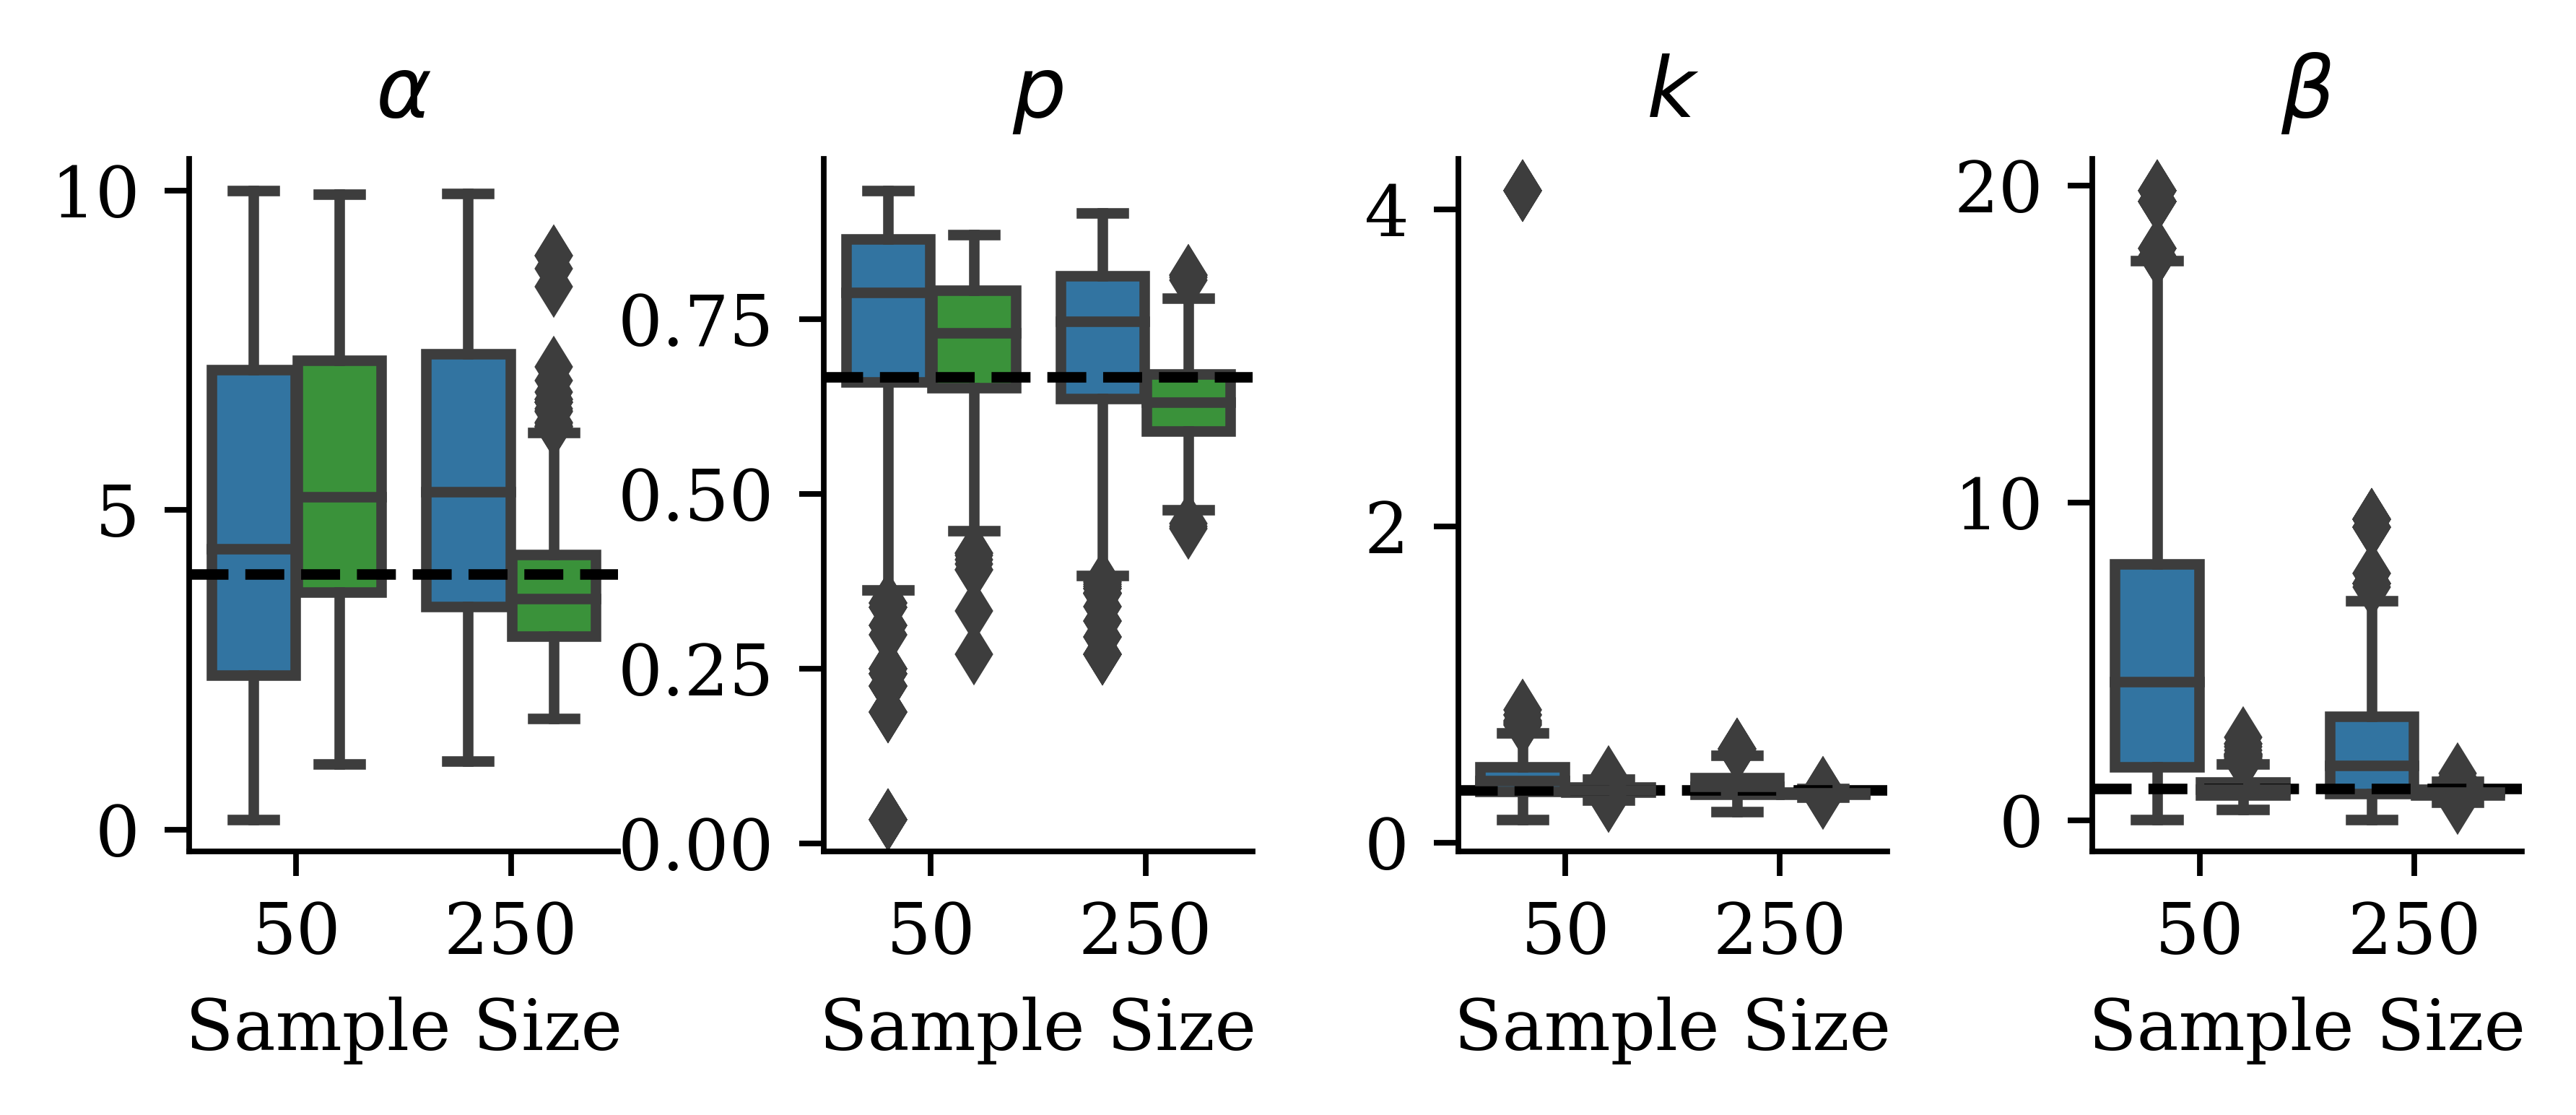

In [13]:
rg = default_rng(1)

n_resample = 1

resampled_post_ABC = pd.DataFrame(
    {"ss": np.concatenate([np.repeat(ss, popSize * n_resample) for ss in sample_sizes])}
)

for l in range(len(params)):
    res_param = np.array([])
    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled = sample[abc.resample(rg, weights, repeats=n_resample)]
        res_param = np.concatenate([res_param, dataResampled])

    resampled_post_ABC[params[l]] = res_param

resampled_post_ABC["posterior"] = np.repeat(
    "ABC", len(sample_sizes) * popSize * n_resample
)
post_samples = pd.concat([resampled_post_ABC, dftrue], axis=0)

post_samples["ss"] = post_samples["ss"].astype(np.int64)

for l in range(len(params)):
    plt.subplot(1, len(params), l + 1)
    plt.tight_layout(pad=0.0)
    sns.boxplot(x="ss", y=params[l], hue="posterior", data=post_samples)
    plt.gca().axhline(θ_True[l], **trueStyle)
    plt.title("$" + params[l] + "$")
    plt.ylabel("")
    plt.xlabel("Sample Size")
    plt.legend("", frameon=False)

sns.despine()
# save_cropped("../Figures/boxplot-test1-negbin-weib.pdf")

## ABC posterior for the Weibull parameters with the claim frequency

In [14]:
params = ("k", "β")
prior = abc.IndependentUniformPrior([(1e-1, 10), (0, 20)], params)

In [15]:
dfABC_freq = pd.DataFrame({"ss": [], "weights": [], "k": [], "β": []})

for ss in sample_sizes:
    xDataSS = df_agg.X[df_agg.time_period <= ss].to_numpy()
    nData = np.array(df_agg.N[df_agg.time_period <= ss])

    model = abc.Model(nData, "weibull", psi, prior)

    %time fit = abc.smc(numItersData, popSize, xDataSS, model, **smcArgs)

    res = pd.DataFrame(
        {
            "ss": np.repeat(ss, popSize),
            "weights": fit.weights,
            "k": fit.samples[:, 0],
            "β": fit.samples[:, 1],
        }
    )

    dfABC_freq = pd.concat([dfABC_freq, res])

Final population dists <= 2.44, ESS = 886
CPU times: user 10.1 s, sys: 813 ms, total: 10.9 s
Wall time: 17.1 s


Final population dists <= 1.95, ESS = 908
CPU times: user 10.9 s, sys: 1 s, total: 11.9 s
Wall time: 42.4 s


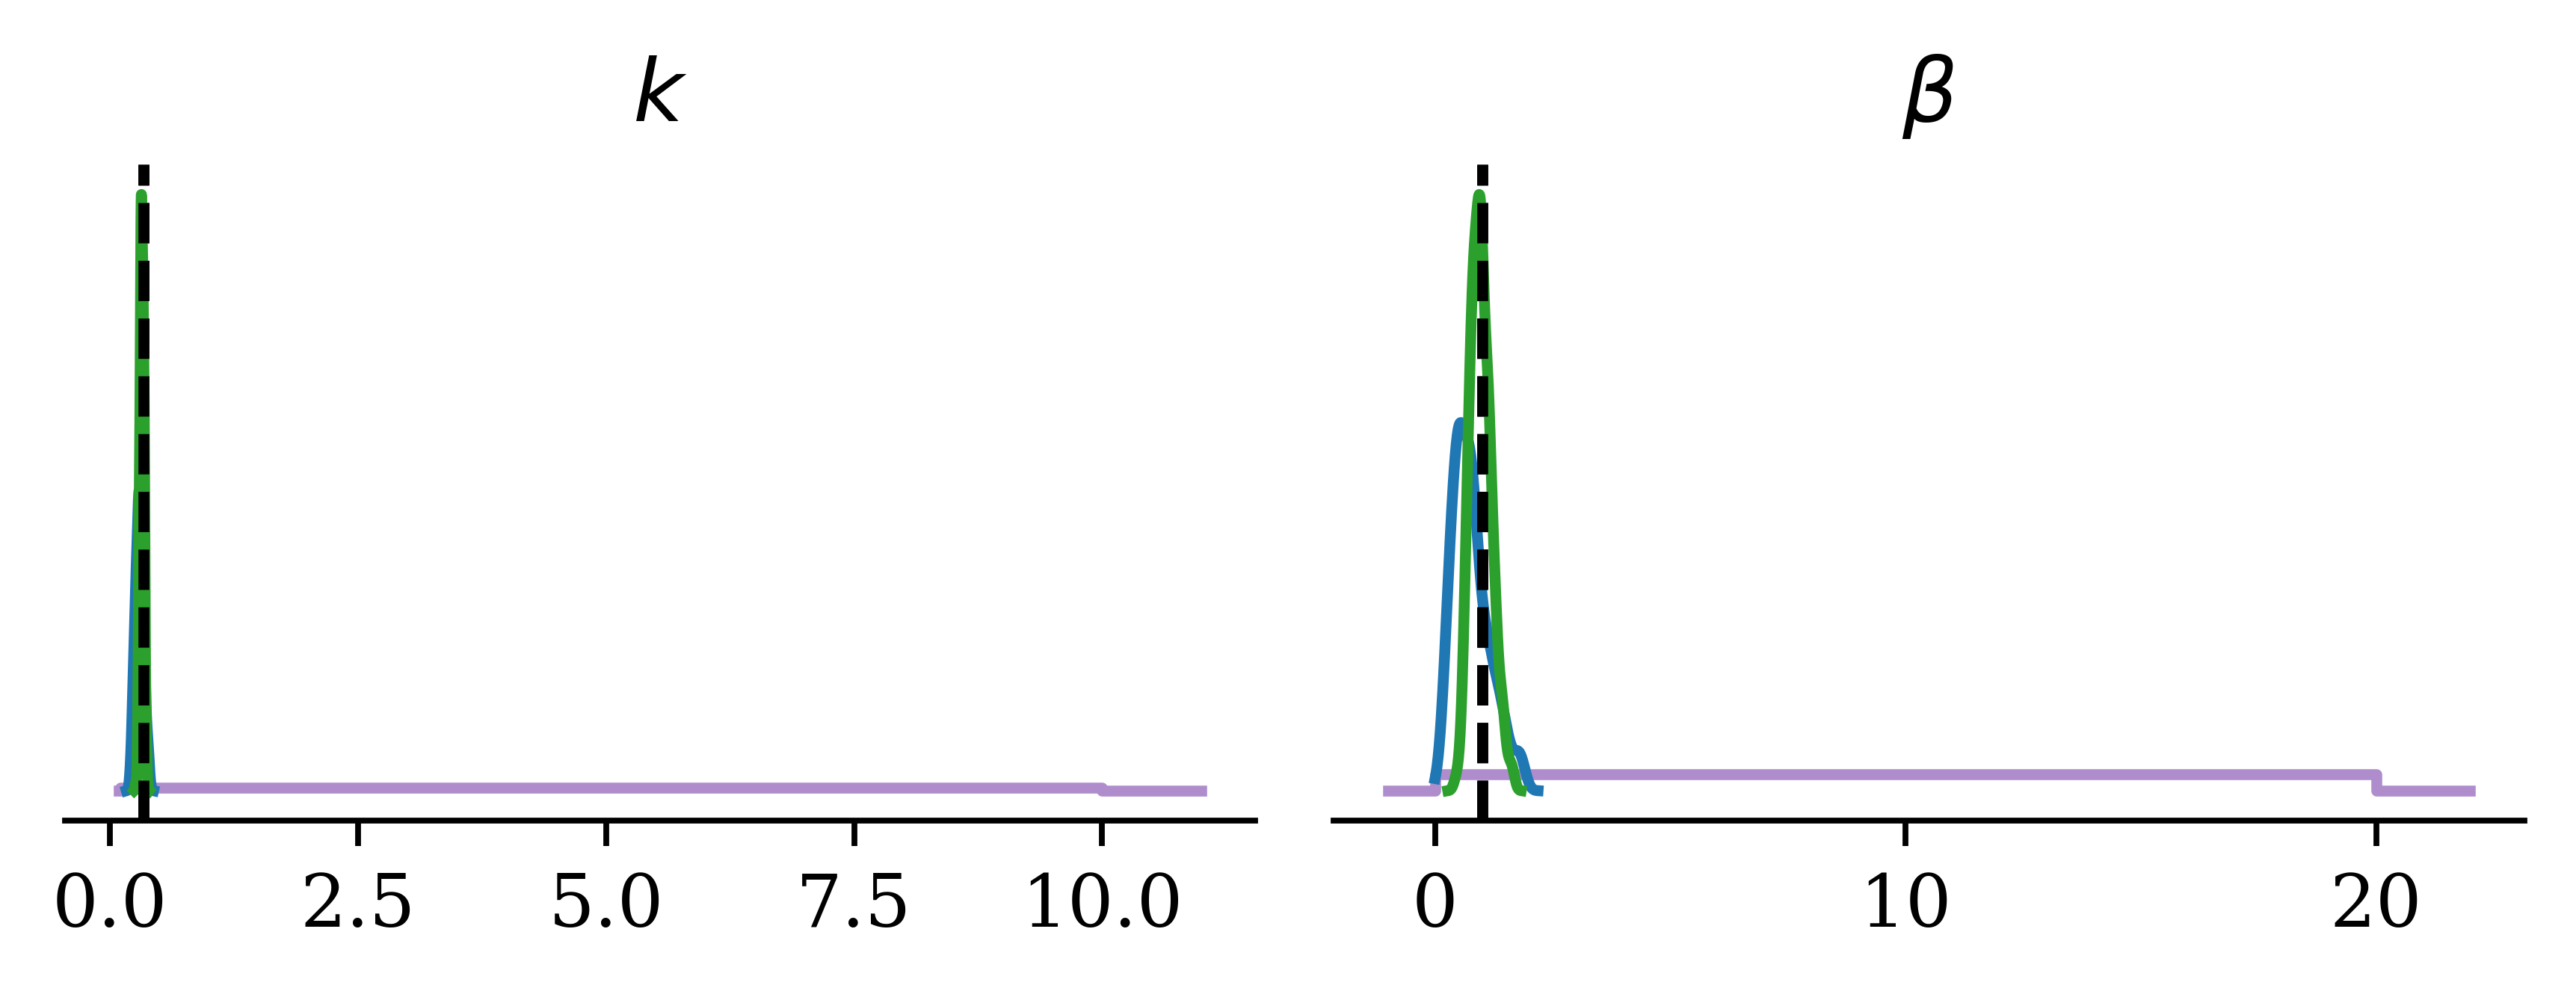

In [16]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC_freq.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abc.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")
        axs[l].axvline(θ_True[l + 2], **trueStyle)
        axs[l].set_title("$" + params[l] + "$")
        axs[l].set_yticks([])

draw_prior(prior, axs)
sns.despine(left=True)
# save_cropped("../Figures/hist-test1-negbin-weib-freq.pdf")

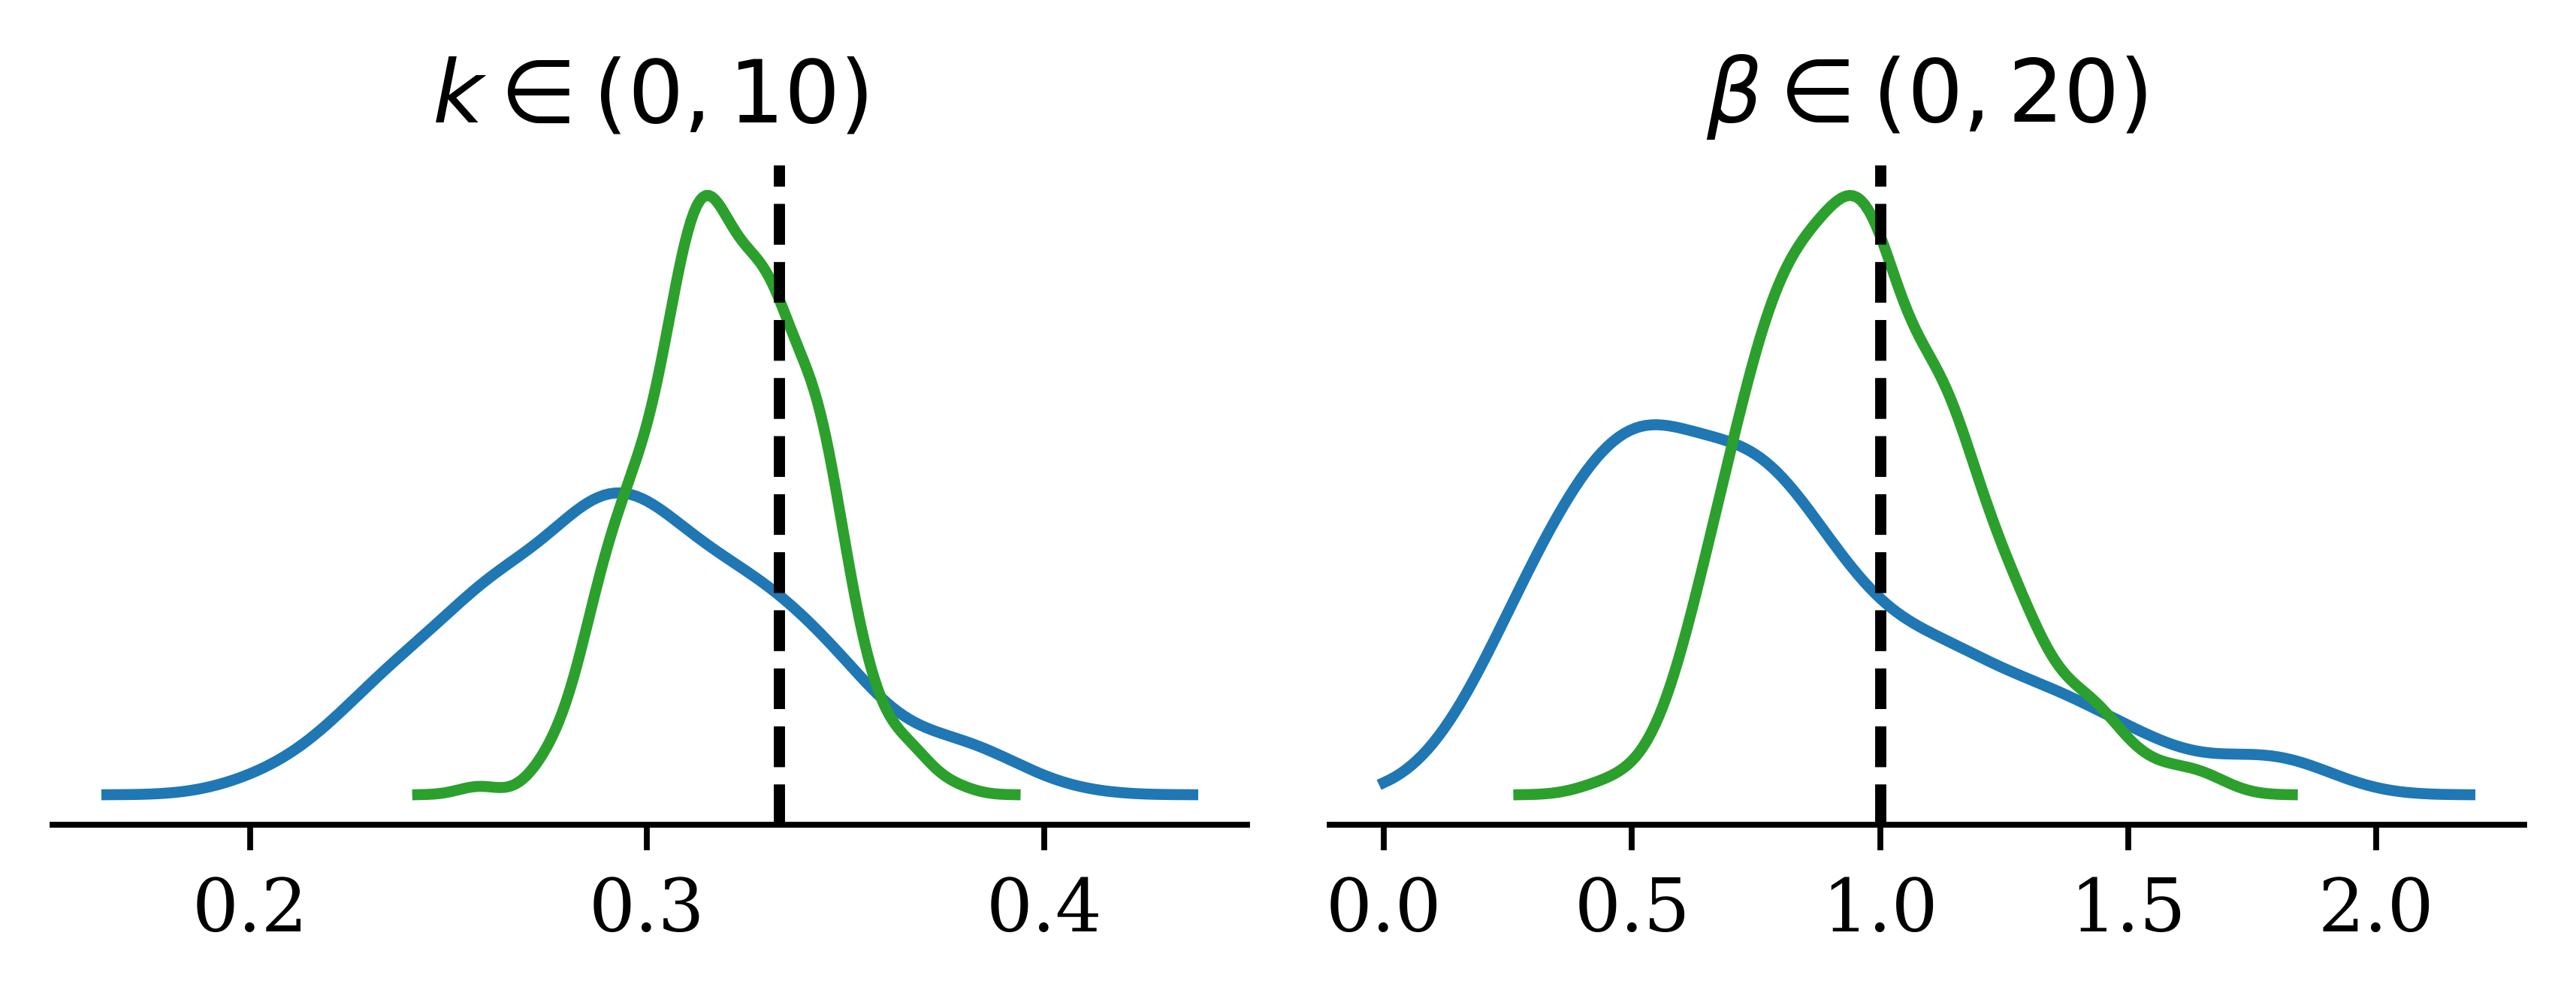

In [17]:
paramsTex = ("k", "\\beta")
fig, axs = plt.subplots(1, len(params), tight_layout=True)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC_freq.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled, xs, ys = abc.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label="ABC")
        axs[l].axvline(θ_True[l + 2], **trueStyle)
        axs[l].set_title("$" + paramsTex[l] + f"\\in ({pLims[0]:.0f}, {pLims[1]:.0f})$")
        axs[l].set_yticks([])

sns.despine(left=True)
save_cropped("../Figures-Slides/hist-test1-negbin-weib-freq-zoom.pdf")

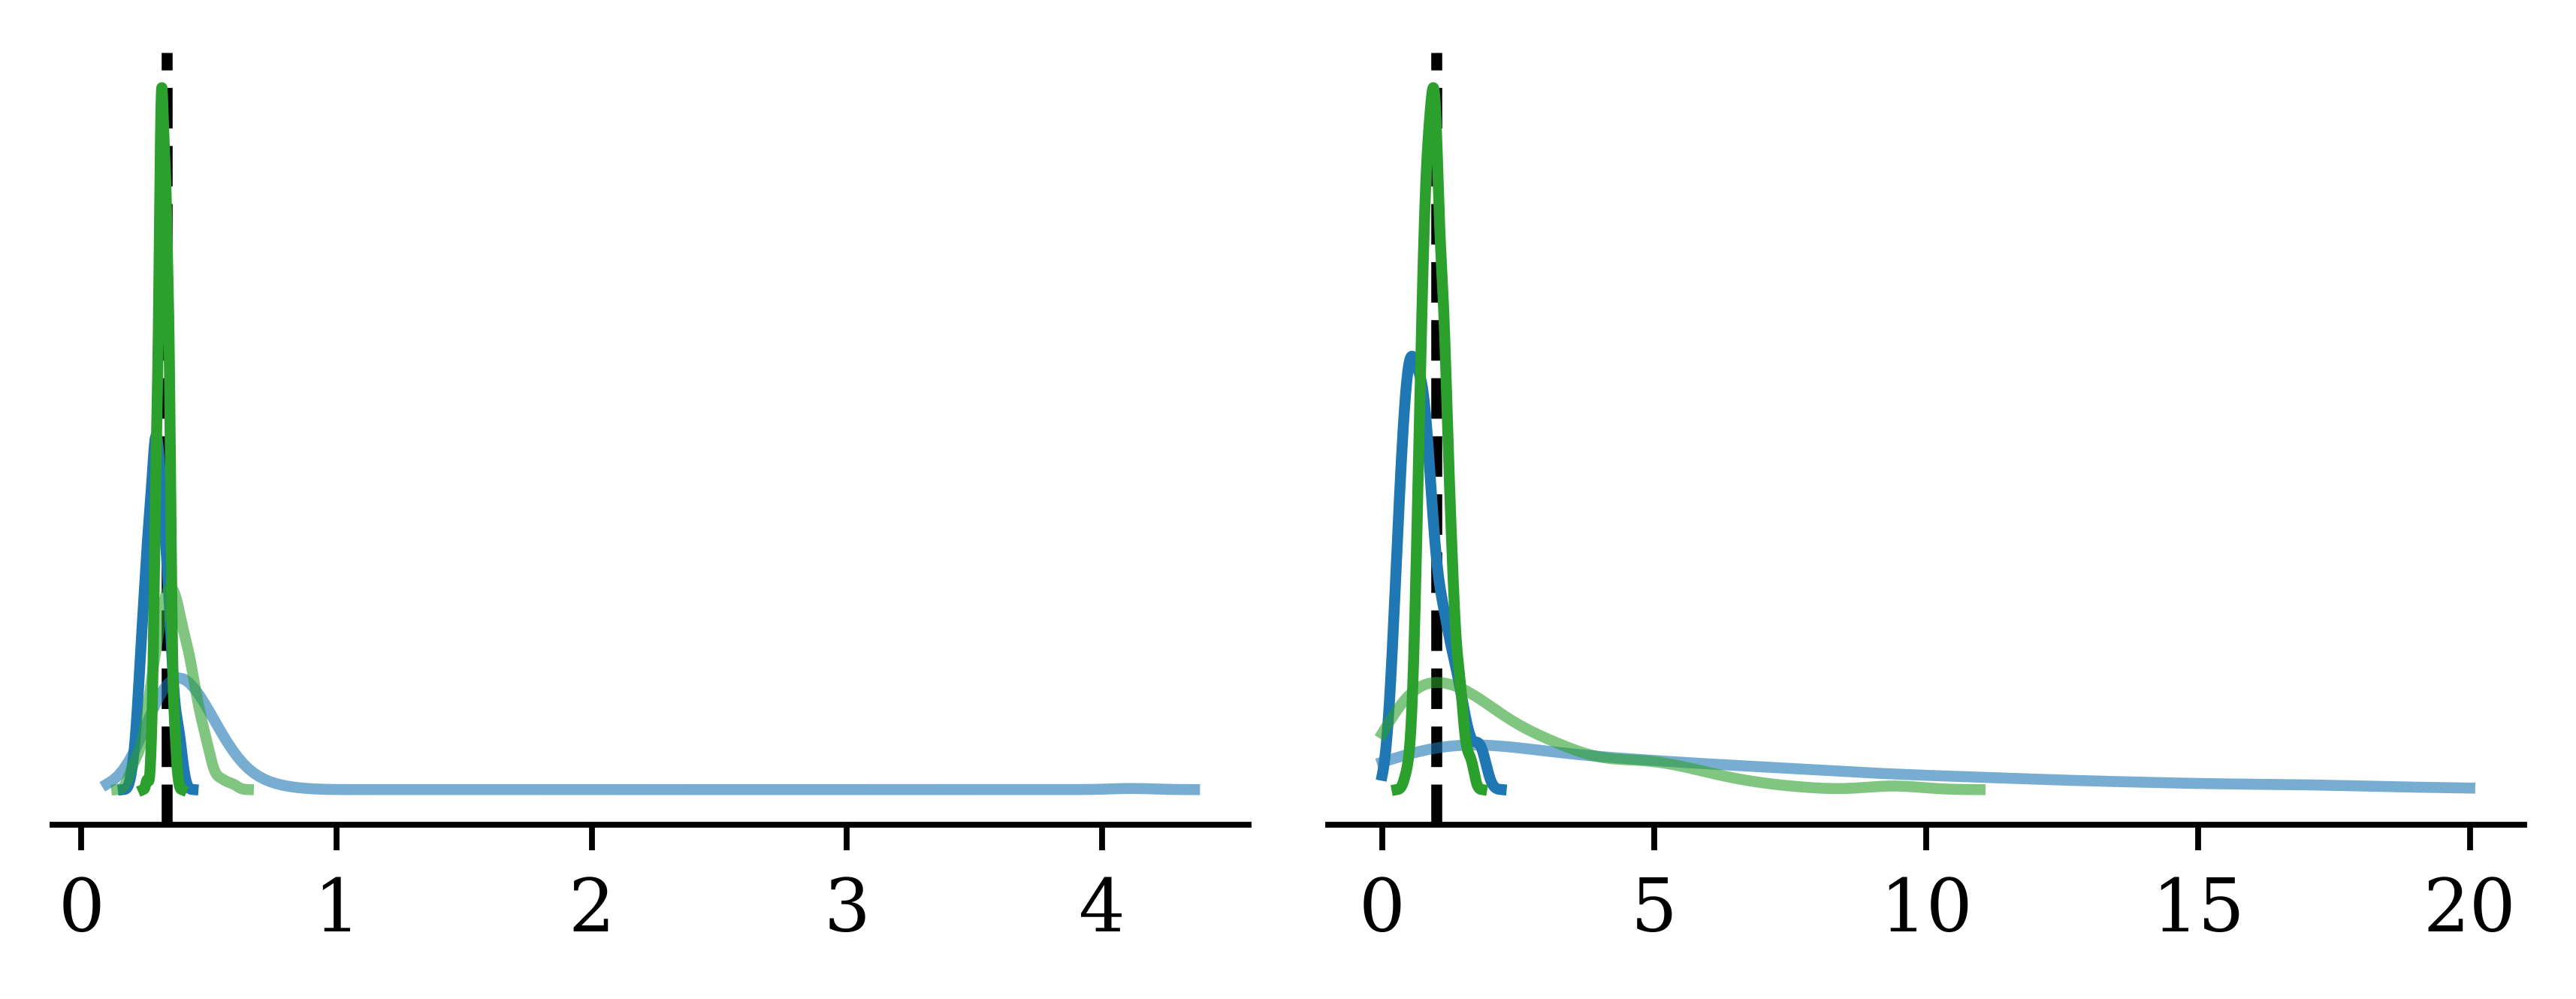

In [18]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)

alphas = (0.6, 1)

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]

    axs[l].axvline(θ_True[l + 2], **trueStyle)
    axs[l].set_yticks([])
    for k, ss in enumerate(sample_sizes):

        for j, df in enumerate((dfABC, dfABC_freq)):
            sampleData = df.query("ss == @ss")
            sample = sampleData[params[l]]
            weights = sampleData["weights"]

            dataResampled, xs, ys = abc.resample_and_kde(sample, weights, clip=pLims)
            axs[l].plot(xs, ys, label="ABC", alpha=alphas[j], c=colors[k])

            # axs[l].set_title("$" + params[l] + "$")

sns.despine(left=True)
save_cropped("../Figures/hist-test1-negbin-weib-both.pdf")

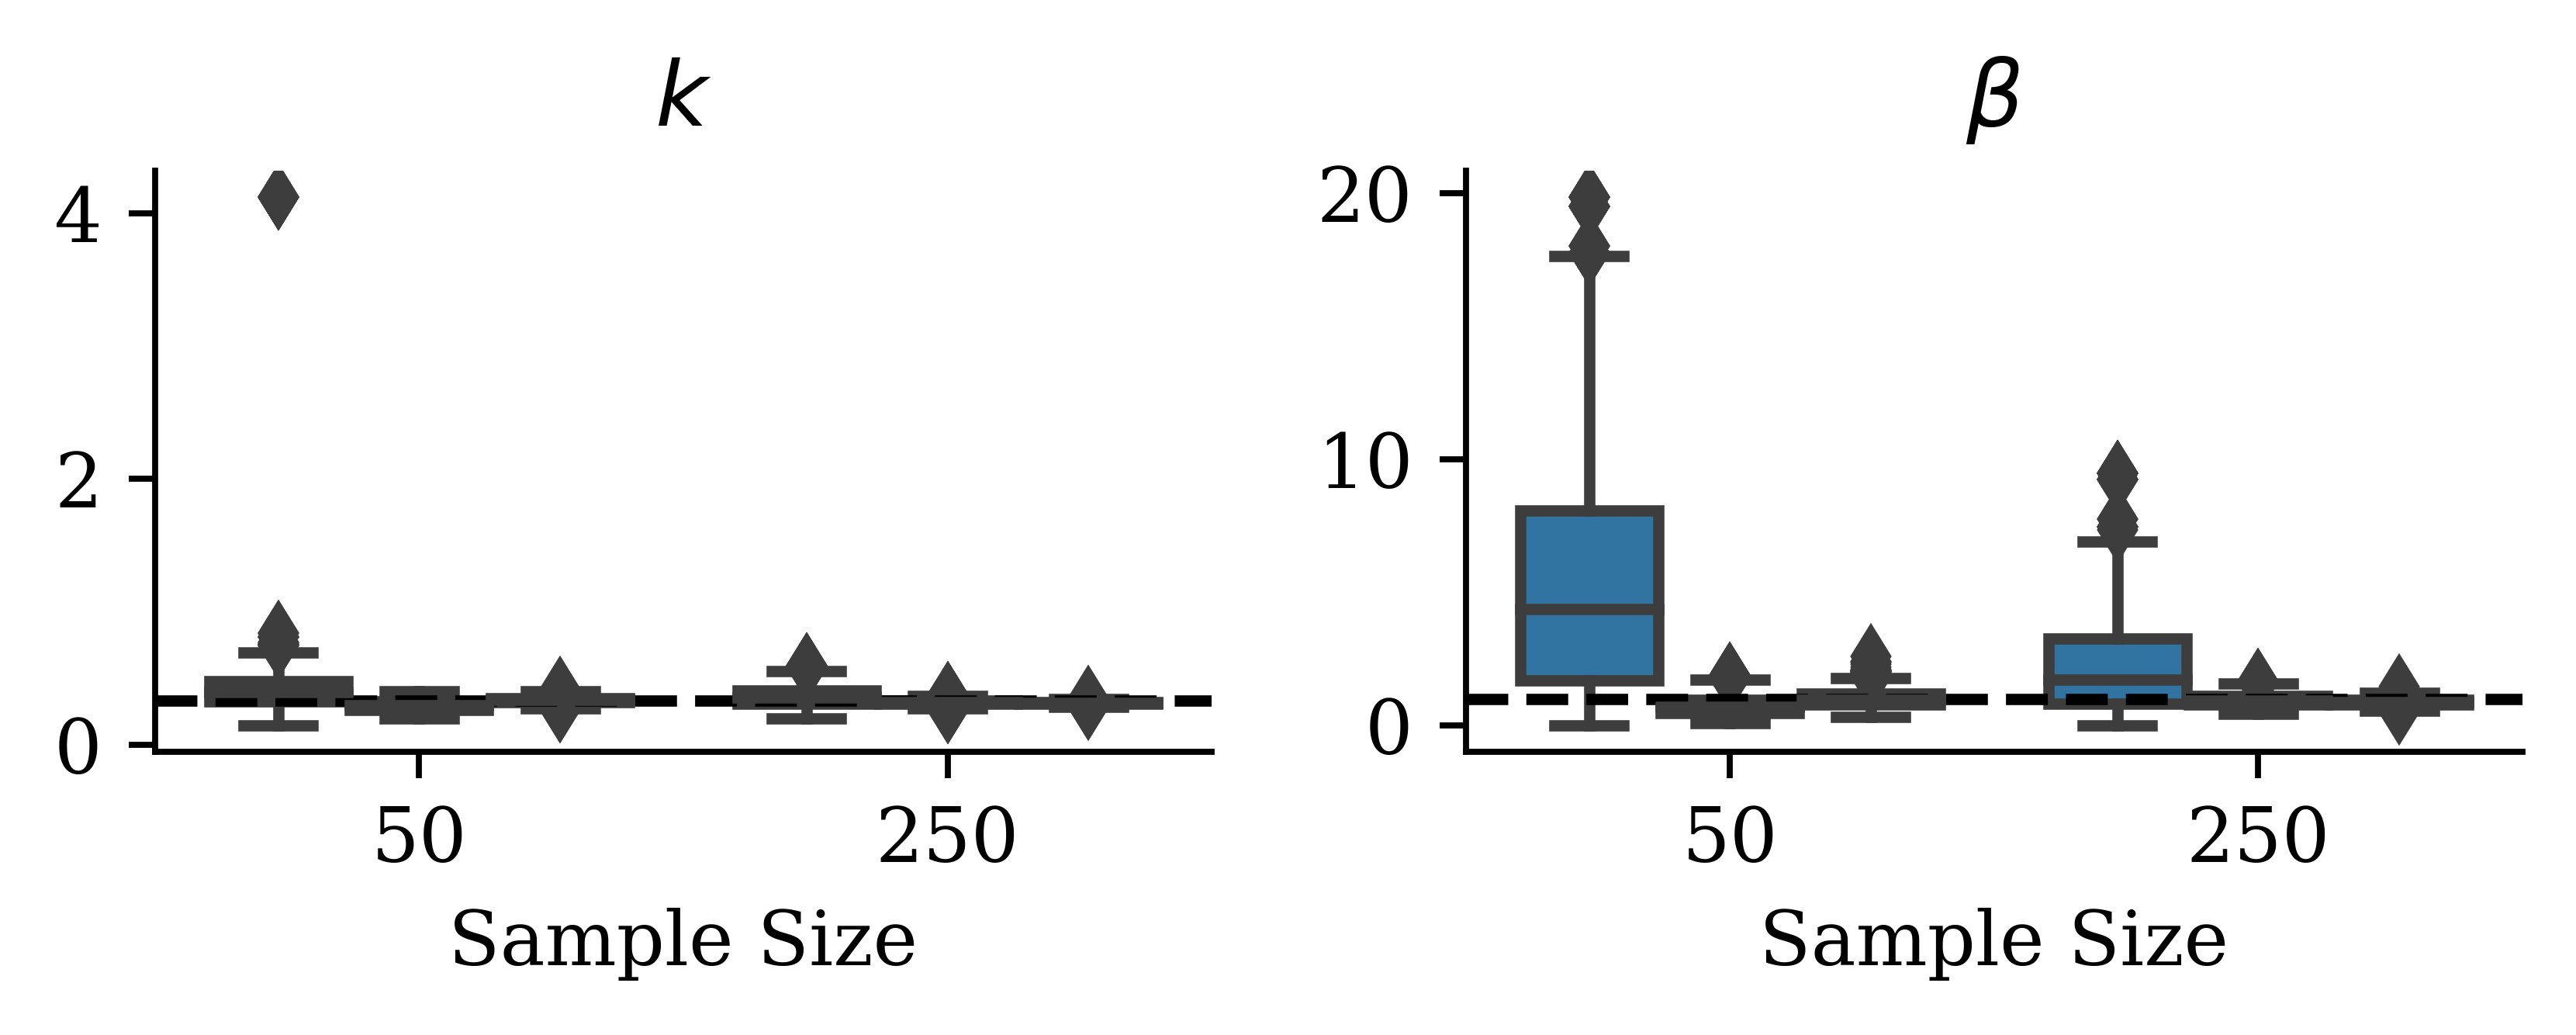

In [19]:
rg = default_rng(1)

resampled_post_ABC_freq = pd.DataFrame(
    {
        "ss": np.concatenate(
            [
                np.repeat(sample_size, popSize * n_resample)
                for sample_size in sample_sizes
            ]
        )
    }
)

for l in range(len(params)):
    res_param = np.array([])
    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC_freq.query("ss == @ss")
        sample = sampleData[params[l]]
        weights = sampleData["weights"]

        dataResampled = sample[abc.resample(rg, weights, repeats=n_resample)]
        res_param = np.concatenate([res_param, dataResampled])

    resampled_post_ABC_freq[params[l]] = res_param

resampled_post_ABC_freq["posterior"] = np.repeat(
    "ABC with freq.", len(sample_sizes) * popSize * n_resample
)
dfV2 = pd.concat([resampled_post_ABC, resampled_post_ABC_freq, dftrue], axis=0)

dfV2["ss"] = dfV2["ss"].astype(np.int64)

for l in range(len(params)):
    plt.subplot(1, len(params), l + 1)
    plt.tight_layout()
    sns.boxplot(x="ss", y=params[l], hue="posterior", data=dfV2)
    plt.axhline(θ_sev[l], **trueStyle)
    plt.title("$" + params[l] + "$")
    plt.ylabel("")
    plt.xlabel("Sample Size")
    plt.legend("", frameon=False)

sns.despine()
# save_cropped("../Figures/boxplot-test1-negbin-weib-freq.pdf")

In [20]:
elapsed = toc()
print(f"Notebook time = {elapsed:.0f} secs = {elapsed/60:.2f} mins")

Notebook time = 401 secs = 6.68 mins


In [21]:
dill.dump_session("Sim_NegBin_Weibull.pkl")